In [1]:
import os
import mysql.connector
from mysql.connector import Error
import time
import matplotlib.pyplot as plt
import numpy as np
from itertools import combinations

def get_column_names(cursor, table_name):
    """Get all column names of a database table"""
    cursor.execute(f"DESCRIBE `{table_name}`")
    return [column[0] for column in cursor.fetchall()]

def pmax_uniqueness_ratio_sql(cursor, table_name, columns):
    """Calculates the Uniqueness Ratio for a given column permutation"""
    if not columns:
        return 0, 0
    columns_list = ', '.join([f"`{col}`" for col in columns])
    query = f"""
        SELECT 
            ((null_rows + unique_rows) / total_rows) AS uniqueness_ratio
        FROM (
            SELECT
                (SELECT COUNT(*) FROM {table_name} WHERE {' OR '.join([f"`{col}` IS NULL" for col in columns])}) AS null_rows,
                (
                    SELECT COUNT(*)
                    FROM (
                        SELECT {columns_list}
                        FROM `{table_name}`
                        WHERE {' AND '.join([f"`{col}` IS NOT NULL" for col in columns])}
                        GROUP BY {columns_list}
                        HAVING COUNT(*) = 1
                    ) AS unique_data
                ) AS unique_rows,
                (SELECT COUNT(*) FROM `{table_name}`) AS total_rows
        ) AS results;
    """
    start_time = time.time()
    cursor.execute(query)
    result = cursor.fetchone()
    execution_time = (time.time() - start_time) * 1000
    ratio = result[0] if result else 0

    return ratio, execution_time


def fit_curve1(lengths, times, degree=2):
    """Fit a polynomial curve of given degree to the lengths and times."""
    coefficients = np.polyfit(lengths, times, degree)
    polynomial = np.poly1d(coefficients)
    fitted_values = polynomial(lengths)
    SS_res = np.sum((times - fitted_values) ** 2)
    SS_tot = np.sum((times - np.mean(times)) ** 2)
    r_squared = 1 - (SS_res / SS_tot)
    return polynomial, coefficients, r_squared

def get_total_rows(cursor, database, table_name):
    cursor.execute(f"SELECT COUNT(*) FROM `{database}`.`{table_name}`;")
    total_rows = cursor.fetchone()[0]
    return total_rows


def main_sql_row_precentage(user, password, database, num, table_name, columns, row_percentages):
    execution_times = {}
    try:
        connection = mysql.connector.connect(user=user, password=password, database=database)
        if connection.is_connected():
            cursor = connection.cursor()

            total_rows = get_total_rows(cursor, database, table_name)
            # print(f"Total Rows in Table '{table_name}': {total_rows}")

            for n in range(num):
                for row_percent in row_percentages:
                    row_num = int(total_rows * row_percent)
                    # print(f"Testing {row_percent}% of rows (~{row_num} rows)")

                    cursor.execute("DROP TABLE IF EXISTS TempTable;")
                    cursor.execute(f"CREATE TABLE TempTable AS SELECT * FROM `{database}`.`{table_name}` LIMIT {row_num};")

                    ratio, exec_time = pmax_uniqueness_ratio_sql(cursor, "TempTable", columns)
                    key = row_percent

                    if key in execution_times:
                        execution_times[key].append(exec_time)
                    else:
                        execution_times[key] = [exec_time]

    except Error as e:
        print("Error:", e)
    finally:
        if connection.is_connected():
            cursor.close()
            connection.close()

    avg_execution_times_precentage = {key: sum(values) / len(values) for key, values in execution_times.items()}
    
    keys = list(avg_execution_times_precentage.keys())
    execution_values = list(avg_execution_times_precentage.values())
    fit_fn, coefficients, r_square = fit_curve1(keys, execution_values, degree=1)

    print(f"Fitting Coefficients: y = {coefficients[0]:.4f} * x + {coefficients[1]:.4f}")
    print(f"R^2: {r_square:.4f}")

    fig = plt.figure(figsize=(10, 6))
    plt.plot(keys, execution_values, 'ko-', label='Avg Execution Time')
    plt.plot(keys, fit_fn(keys), 'b--', label=f'Linear Fit (R^2={r_square:.4f})')

    for i, key in enumerate(keys):
        plt.text(key, execution_values[i], f'{execution_values[i]:.4f}', fontsize=20, ha='right')

    plt.xlabel('Percentage of Rows (%)', fontsize=20)
    plt.ylabel('Time in Milliseconds (t)', fontsize=20)
    plt.title(f'Runtime vs Number of Rows\nCurrent Key: {columns}  Table: {table_name}', fontsize=20)
    plt.grid(True)
    # plt.legend()
    
    equation_text = f"y = {coefficients[0]:.4f} * x + {coefficients[1]:.4f}"
    plt.text(0.05, 0.95, equation_text, transform=plt.gca().transAxes, fontsize=16, color='blue', verticalalignment='top')

    plt.tight_layout()
    
    # Save the plot
    desktop_path = os.path.join(os.path.expanduser("~"), "Desktop/rowRunTime")
    file_name = f"{table_name}.png"
    file_path = os.path.join(desktop_path, file_name)

    fig.tight_layout()
    plt.savefig(file_path, dpi=300)  # Save plot to desktop with high resolution
    plt.show()

    print(f"Plot saved successfully as {file_path}")
    
    plt.show()

    return avg_execution_times_precentage


In [2]:
def main_sql_row(user, password, database, num, table_name, columns, row_nums):
    execution_times = {}
    try:
        connection = mysql.connector.connect(user=user, password=password, database=database)
        if connection.is_connected():
            cursor = connection.cursor()

            for n in range(num):
                for row_num in row_nums:
                    cursor.execute("DROP TABLE IF EXISTS TempTable;")
                    cursor.execute(f"CREATE TABLE TempTable AS SELECT * FROM `{database}`.`{table_name}` LIMIT {row_num};")

                    ratio, exec_time = pmax_uniqueness_ratio_sql(cursor, "TempTable", columns)
                    key = row_num

                    if key in execution_times:
                        execution_times[key].append(exec_time)
                    else:
                        execution_times[key] = [exec_time]

    except Error as e:
        print("Error:", e)
    finally:
        if connection.is_connected():
            cursor.close()
            connection.close()

    avg_execution_times = {key: sum(values) / len(values) for key, values in execution_times.items()}
    return avg_execution_times

# Master Table


In [3]:
import random
l1 = {
    'Goalies': ['playerID', 'year', 'tmID', 'lgID', 'GP', 'Min', 'W', 'L', 'GA', 'stint'], 'Teams': ['year', 'tmID', 'name', 'lgID', 'franchID', 'playoff', 'confID', 'divID', 'GF', 'GA'],
    'TeamVsTeam': ['year', 'lgID', 'tmID', 'oppID', 'W', 'L', 'T', 'OTL'],
    'SeriesPost': ['year', 'tmIDWinner', 'tmIDLoser', 'round', 'series', 'lgIDWinner', 'lgIDLoser', 'GoalsWinner', 'GoalsLoser', 'note'], 
    'TeamsPost': ['year', 'tmID', 'lgID', 'W', 'G', 'PIM', 'GA', 'GF', 'L', 'T'],
    'Coaches': ['coachID', 'year', 'tmID', 'lgID', 'stint', 'g', 'w', 'l', 't', 'postg'],
    'Scoring': ['playerID', 'year', 'tmID', 'lgID', 'stint', 'pos', 'GP', 'G', 'A', 'postG'], 
    'TeamSplits': ['year', 'tmID', 'lgID', 'hW', 'hL', 'hOTL', 'rW', 'rL', 'rT', 'rOTL'], 
    'AwardsPlayers': ['playerID', 'award', 'year', 'lgID', 'note', 'pos'], 
    'Master': ['playerID', 'coachID', 'firstName', 'lastName', 'nameGiven', 'legendsID', 'ihdbID', 'hrefID', 'birthYear', 'birthCountry'],
    'HOF': ['hofID', 'year', 'name', 'category'],
    'AwardsMisc': ['name', 'ID', 'award', 'year', 'lgID', 'note'],
    'Abbrev': ['Type', 'Code', 'Fullname'],
    'TeamsHalf': ['year', 'tmID', 'half', 'lgID', 'rank'],
    'GoaliesShootout': ['playerID', 'year', 'stint', 'tmID', 'W', 'L', 'SA', 'GA'],
    'ScoringSup': ['playerID', 'year', 'PPA', 'SHA'],
    'CombinedShutouts': ['year', 'month', 'date', 'tmID', 'oppID', 'R/P', 'IDgoalie1', 'IDgoalie2'],
    'ScoringSC': ['playerID', 'year', 'tmID', 'lgID', 'pos', 'GP'],
    'GoaliesSC': ['playerID', 'year', 'tmID', 'lgID', 'GP'],
    'ScoringShootout': ['playerID', 'year', 'tmID', 'stint', 'S', 'G', 'GDG'],
    'TeamsSC': ['year', 'tmID', 'lgID', 'G', 'W', 'L', 'T']
}
random_l1 = {}
for key, value in l1.items():
    random_numbers=random.sample(range(len(value)), 3)
    random_l1[key] = random_numbers
    
for key ,value in random_l1.items():
    print(key, value)
# Generate six non-repeating random numbers between 0 and 9
# random_numbers = random.sample(range(len(master_columns)), 4)
# print(random_numbers)


Goalies [5, 1, 7]
Teams [8, 9, 4]
TeamVsTeam [2, 6, 4]
SeriesPost [8, 6, 3]
TeamsPost [4, 6, 2]
Coaches [1, 5, 3]
Scoring [7, 4, 0]
TeamSplits [3, 1, 6]
AwardsPlayers [4, 0, 2]
Master [7, 4, 6]
HOF [0, 2, 1]
AwardsMisc [1, 4, 3]
Abbrev [1, 2, 0]
TeamsHalf [0, 3, 1]
GoaliesShootout [4, 6, 5]
ScoringSup [1, 0, 3]
CombinedShutouts [1, 7, 5]
ScoringSC [0, 2, 1]
GoaliesSC [4, 1, 2]
ScoringShootout [6, 1, 4]
TeamsSC [6, 3, 1]


In [4]:
columns_l1 = {}
for key, value in random_l1.items():
    columns=[]
    l1_columns = l1[key]
    # print(l1_columns)
    for v in value:
        columns.append(l1_columns[v])
    random_l1[key] = columns

# random_l1 stores the random key selected for each table
for key,value in random_l1.items():
    print(key, value)

Goalies ['Min', 'year', 'L']
Teams ['GF', 'GA', 'franchID']
TeamVsTeam ['tmID', 'T', 'W']
SeriesPost ['GoalsLoser', 'lgIDLoser', 'round']
TeamsPost ['G', 'GA', 'lgID']
Coaches ['year', 'g', 'lgID']
Scoring ['G', 'stint', 'playerID']
TeamSplits ['hW', 'tmID', 'rW']
AwardsPlayers ['note', 'playerID', 'year']
Master ['hrefID', 'nameGiven', 'ihdbID']
HOF ['hofID', 'name', 'year']
AwardsMisc ['ID', 'lgID', 'year']
Abbrev ['Code', 'Fullname', 'Type']
TeamsHalf ['year', 'lgID', 'tmID']
GoaliesShootout ['W', 'SA', 'L']
ScoringSup ['year', 'playerID', 'SHA']
CombinedShutouts ['month', 'IDgoalie2', 'R/P']
ScoringSC ['playerID', 'tmID', 'year']
GoaliesSC ['GP', 'year', 'tmID']
ScoringShootout ['GDG', 'year', 'S']
TeamsSC ['T', 'G', 'tmID']


Fitting Coefficients: y = 4.2986 * x + 0.9815
R^2: 0.9909


/var/folders/m4/0zy7bxr96t58gcdnb528ryw00000gn/T/ipykernel_27434/4096822074.py:151: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


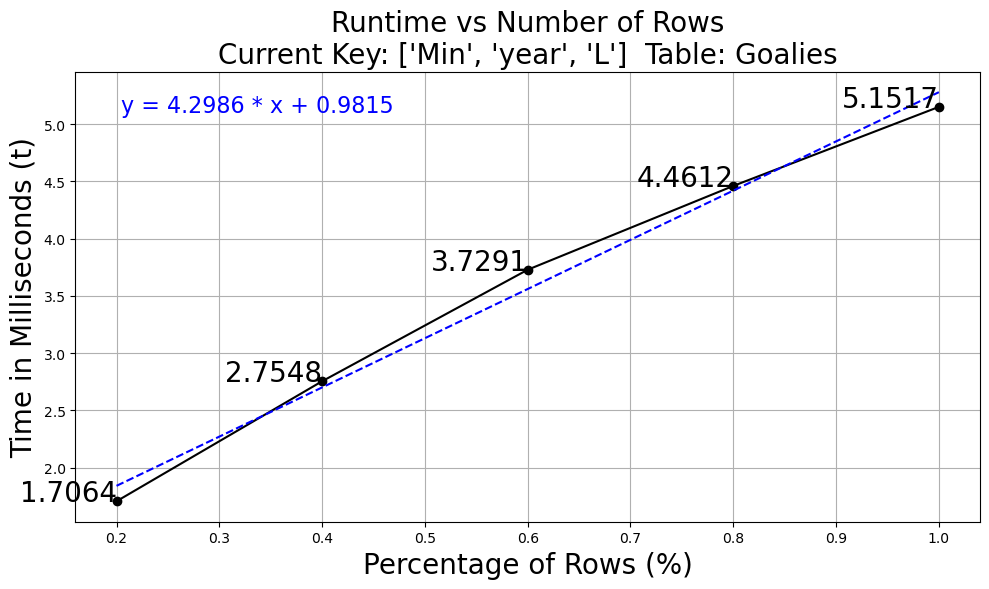

Plot saved successfully as /Users/zihuiyang/Desktop/rowRunTime/Goalies.png
Fitting Coefficients: y = 1.3738 * x + 0.5927
R^2: 0.9995


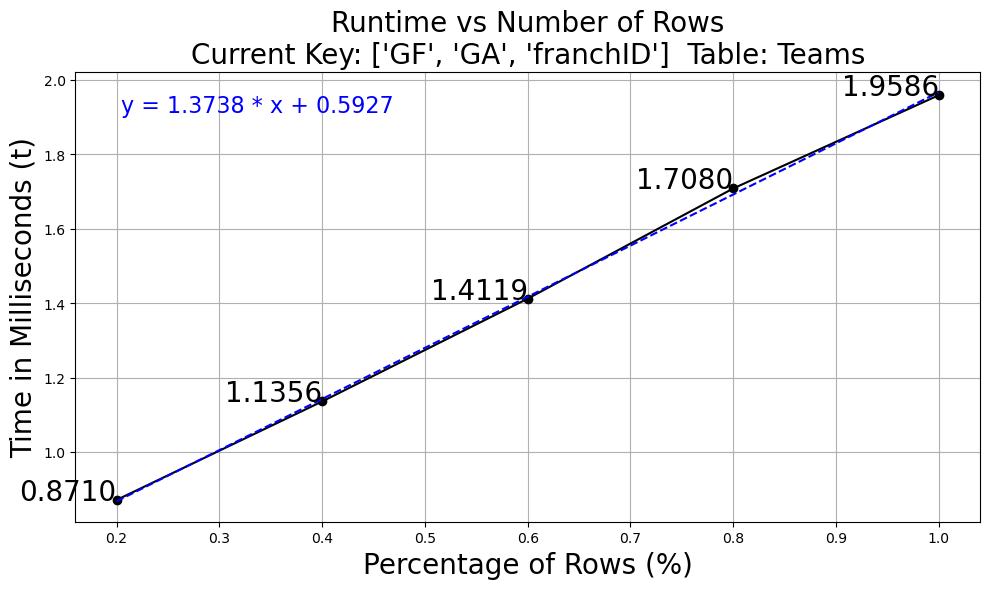

Plot saved successfully as /Users/zihuiyang/Desktop/rowRunTime/Teams.png
Fitting Coefficients: y = 14.0253 * x + 1.4736
R^2: 0.9904


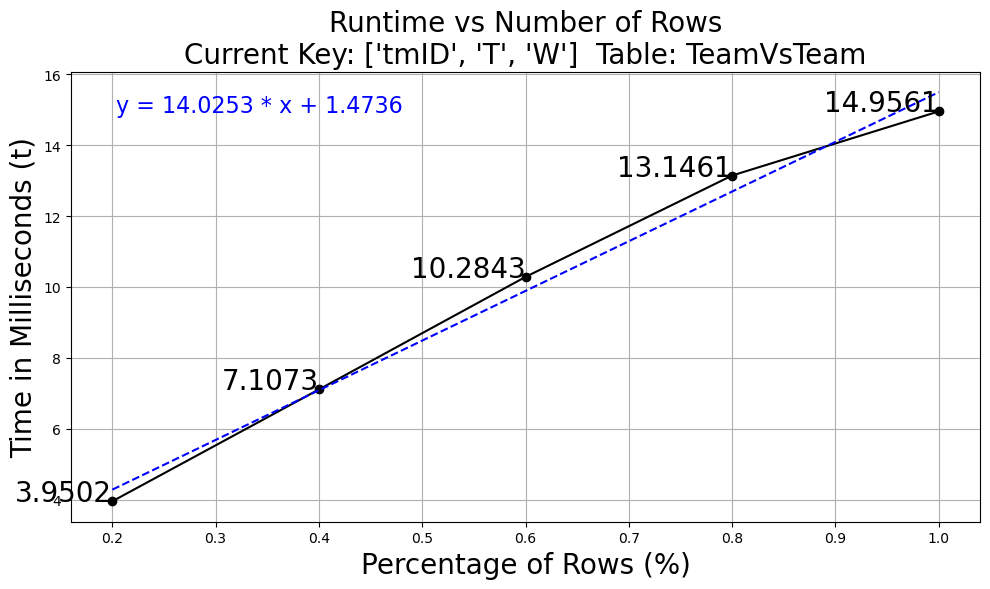

Plot saved successfully as /Users/zihuiyang/Desktop/rowRunTime/TeamVsTeam.png
Fitting Coefficients: y = 0.6069 * x + 0.6156
R^2: 0.9993


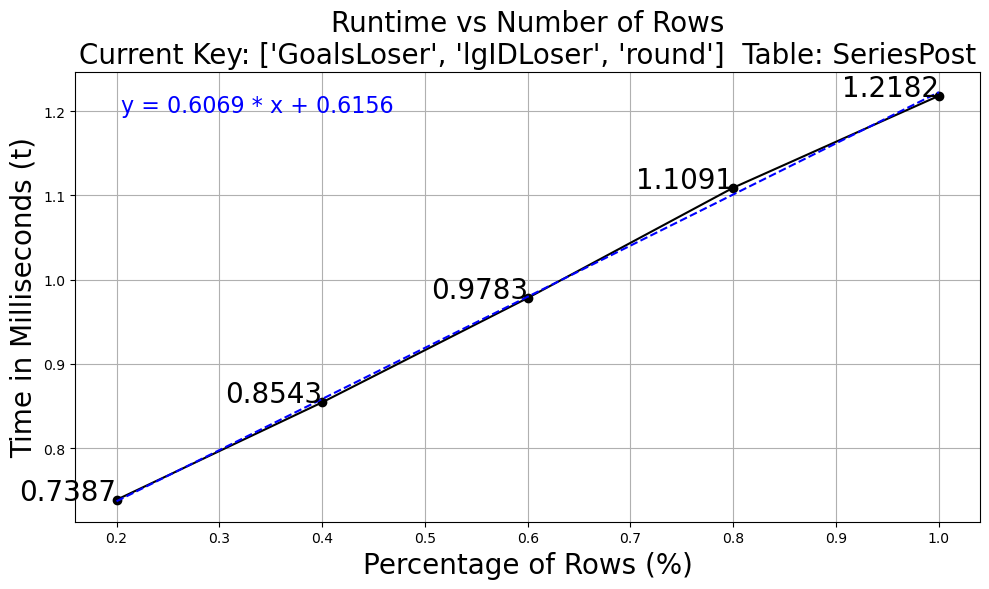

Plot saved successfully as /Users/zihuiyang/Desktop/rowRunTime/SeriesPost.png
Fitting Coefficients: y = 0.6967 * x + 0.6990
R^2: 0.9976


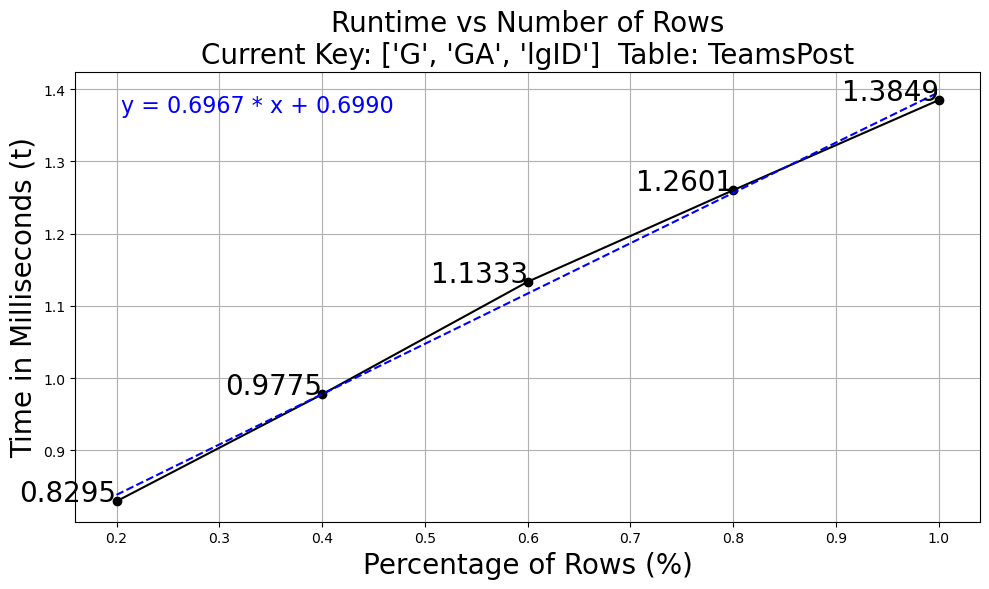

Plot saved successfully as /Users/zihuiyang/Desktop/rowRunTime/TeamsPost.png
Fitting Coefficients: y = 1.3857 * x + 0.7790
R^2: 0.9992


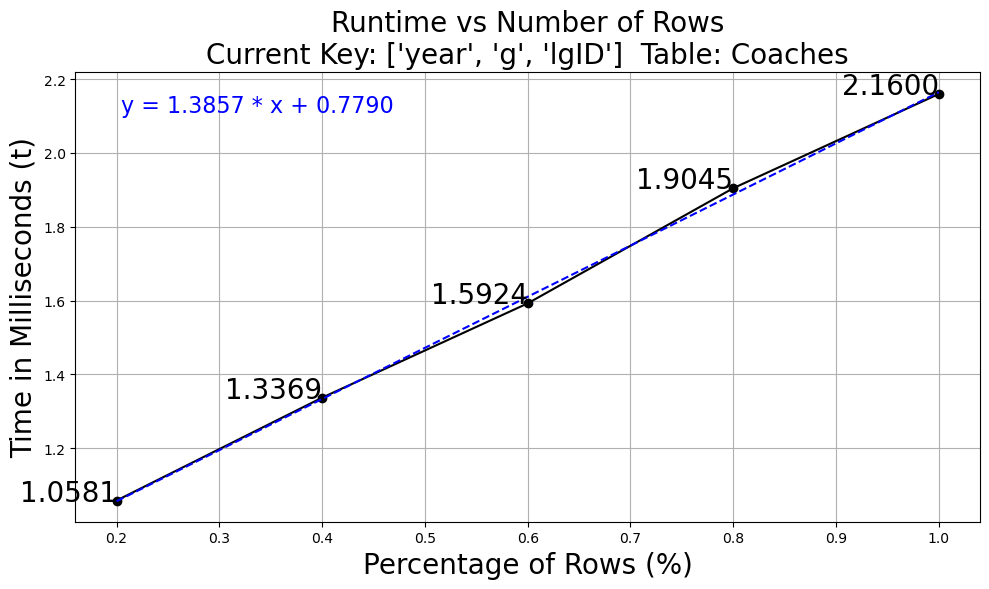

Plot saved successfully as /Users/zihuiyang/Desktop/rowRunTime/Coaches.png
Fitting Coefficients: y = 43.0009 * x + 1.4420
R^2: 0.9936


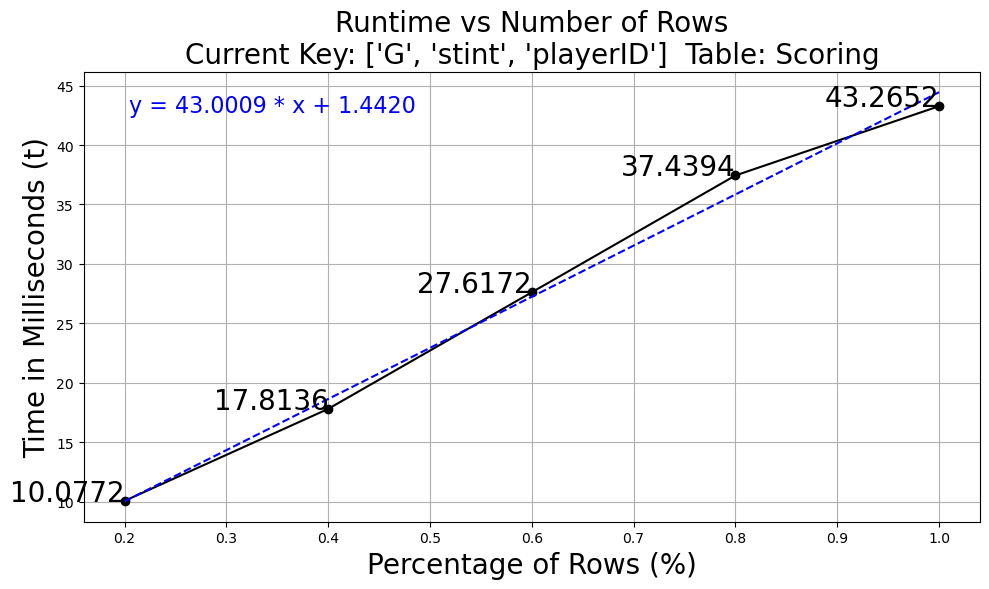

Plot saved successfully as /Users/zihuiyang/Desktop/rowRunTime/Scoring.png
Fitting Coefficients: y = 1.3700 * x + 0.7078
R^2: 0.9995


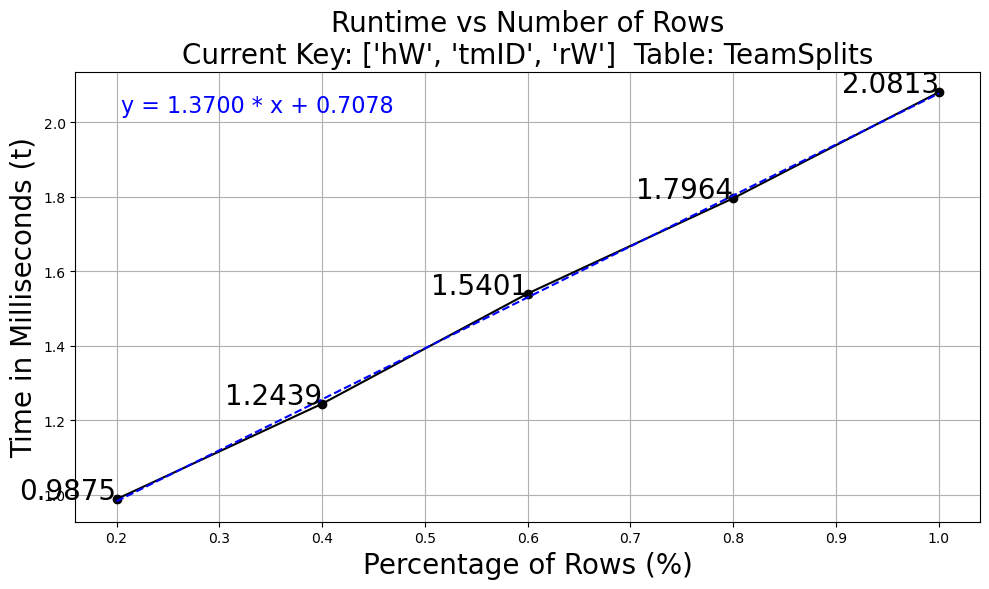

Plot saved successfully as /Users/zihuiyang/Desktop/rowRunTime/TeamSplits.png
Fitting Coefficients: y = 0.7485 * x + 0.6362
R^2: 0.9991


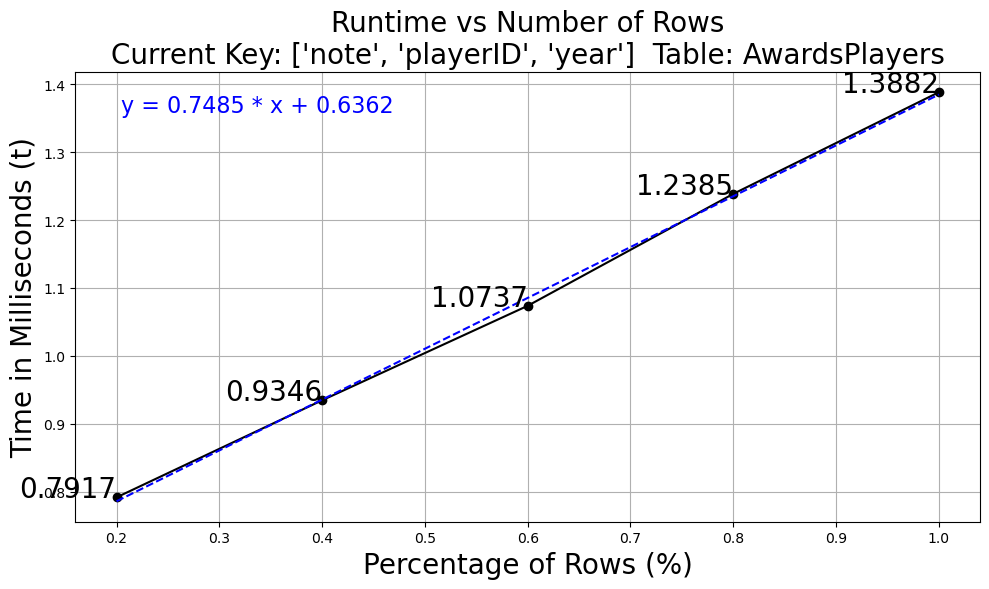

Plot saved successfully as /Users/zihuiyang/Desktop/rowRunTime/AwardsPlayers.png
Fitting Coefficients: y = 8.1752 * x + 0.7891
R^2: 0.9993


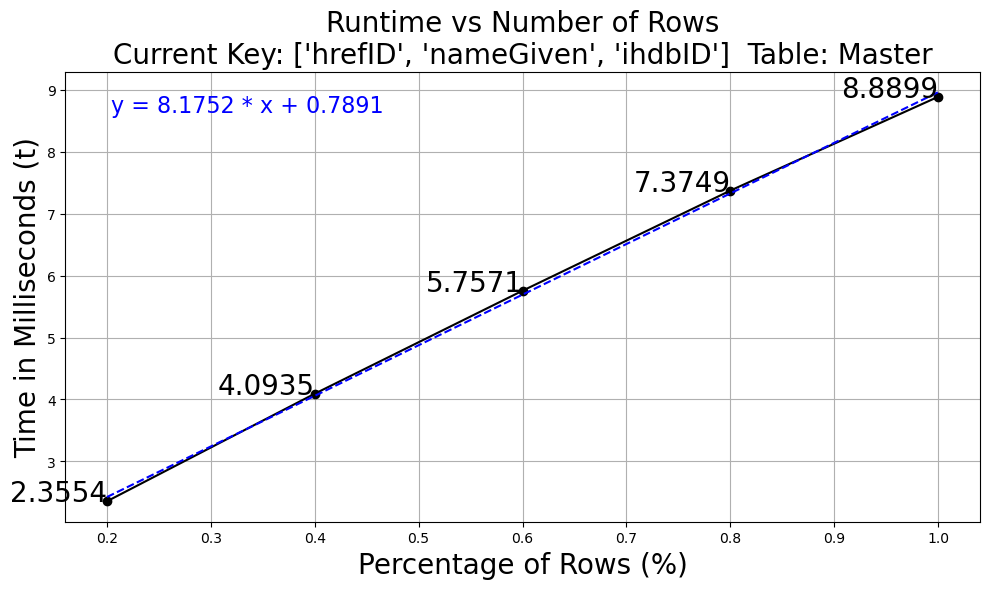

Plot saved successfully as /Users/zihuiyang/Desktop/rowRunTime/Master.png
Fitting Coefficients: y = 0.3796 * x + 0.6223
R^2: 0.9937


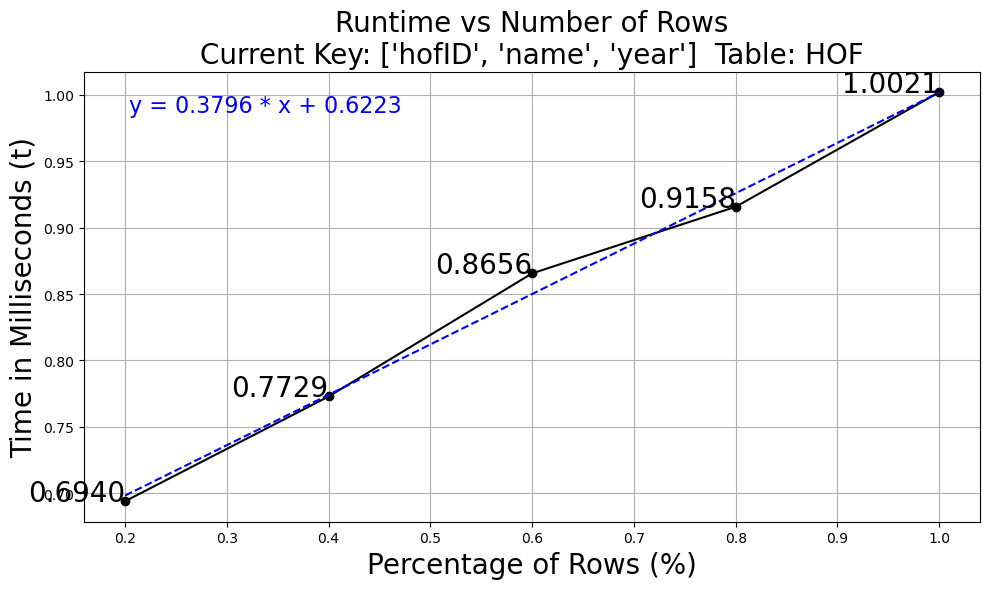

Plot saved successfully as /Users/zihuiyang/Desktop/rowRunTime/HOF.png
Fitting Coefficients: y = 0.0937 * x + 0.6357
R^2: 0.8920


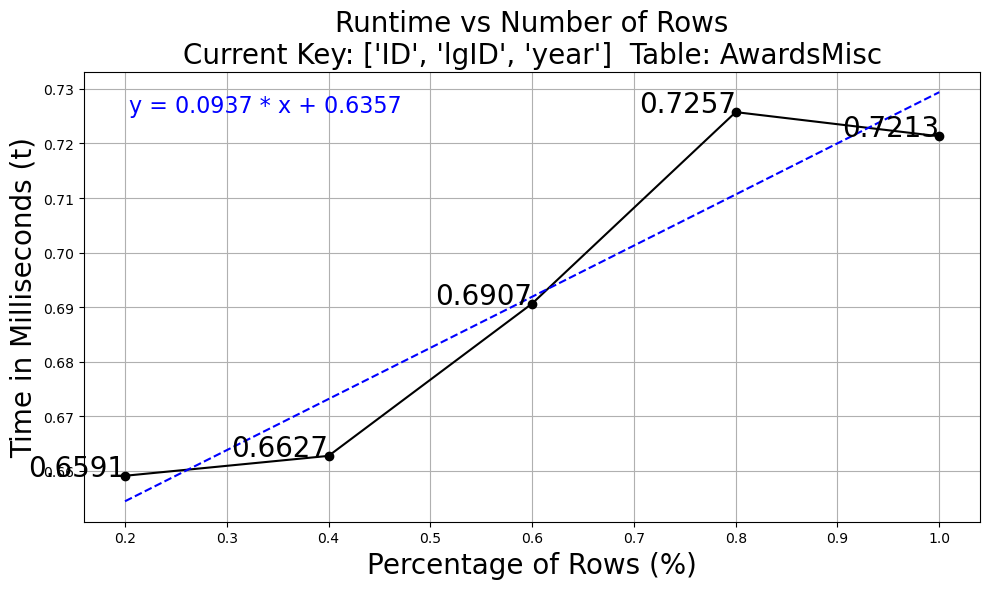

Plot saved successfully as /Users/zihuiyang/Desktop/rowRunTime/AwardsMisc.png
Fitting Coefficients: y = 0.0809 * x + 0.6156
R^2: 0.9658


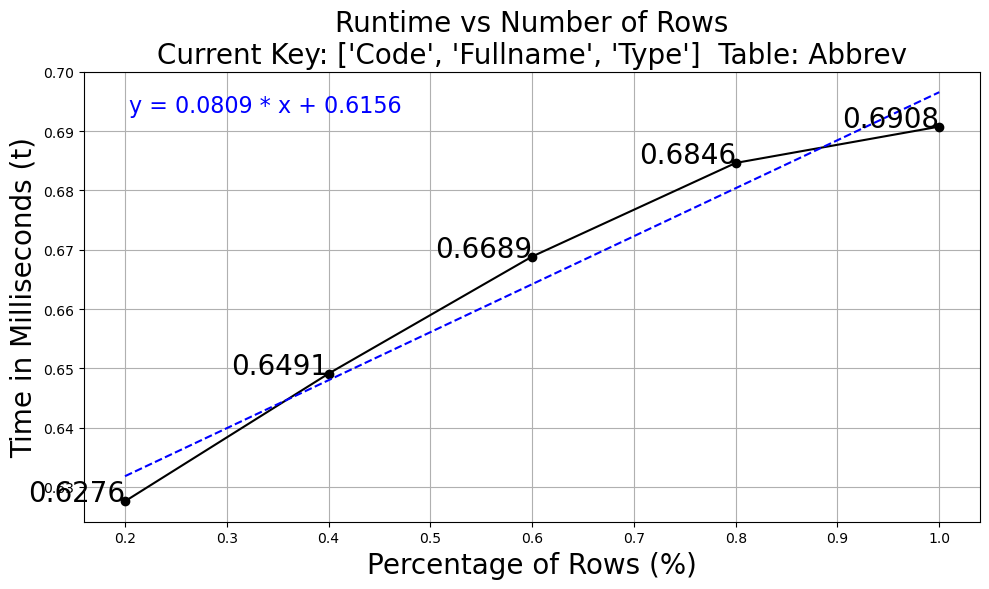

Plot saved successfully as /Users/zihuiyang/Desktop/rowRunTime/Abbrev.png
Fitting Coefficients: y = 0.0369 * x + 0.6358
R^2: 0.5220


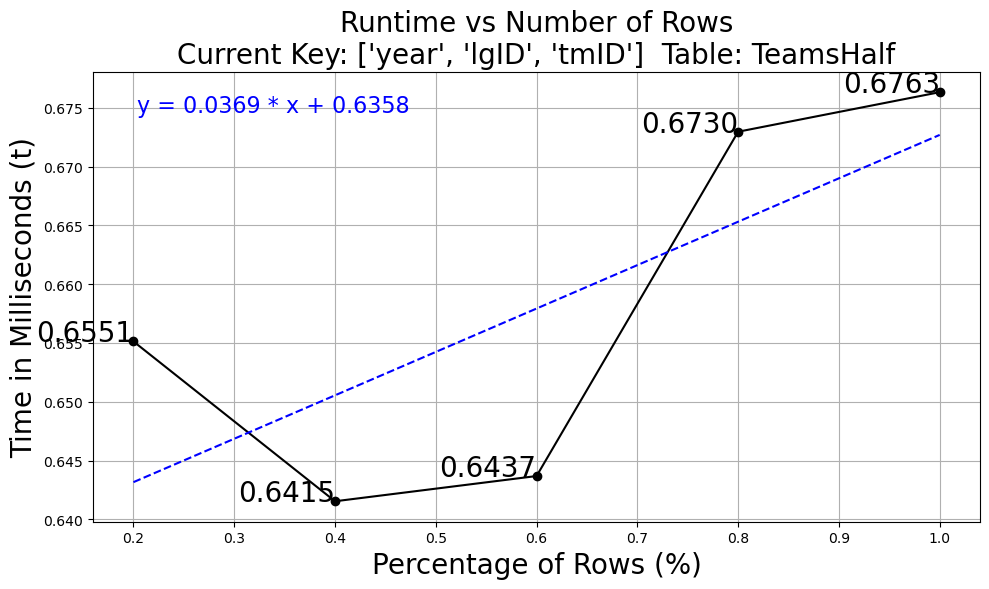

Plot saved successfully as /Users/zihuiyang/Desktop/rowRunTime/TeamsHalf.png
Fitting Coefficients: y = 0.2587 * x + 0.6772
R^2: 0.9984


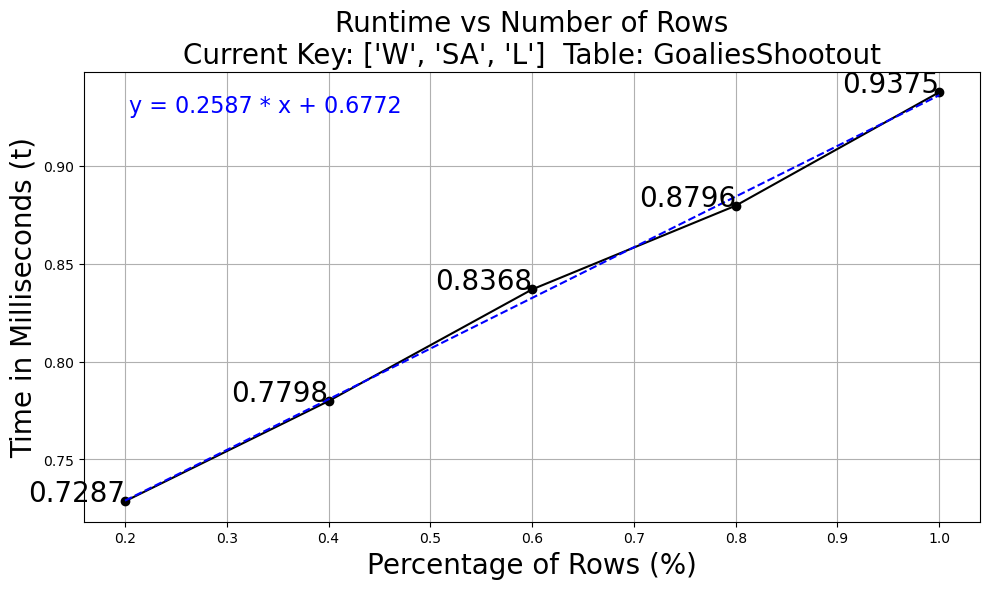

Plot saved successfully as /Users/zihuiyang/Desktop/rowRunTime/GoaliesShootout.png
Fitting Coefficients: y = 0.0928 * x + 0.6433
R^2: 0.8465


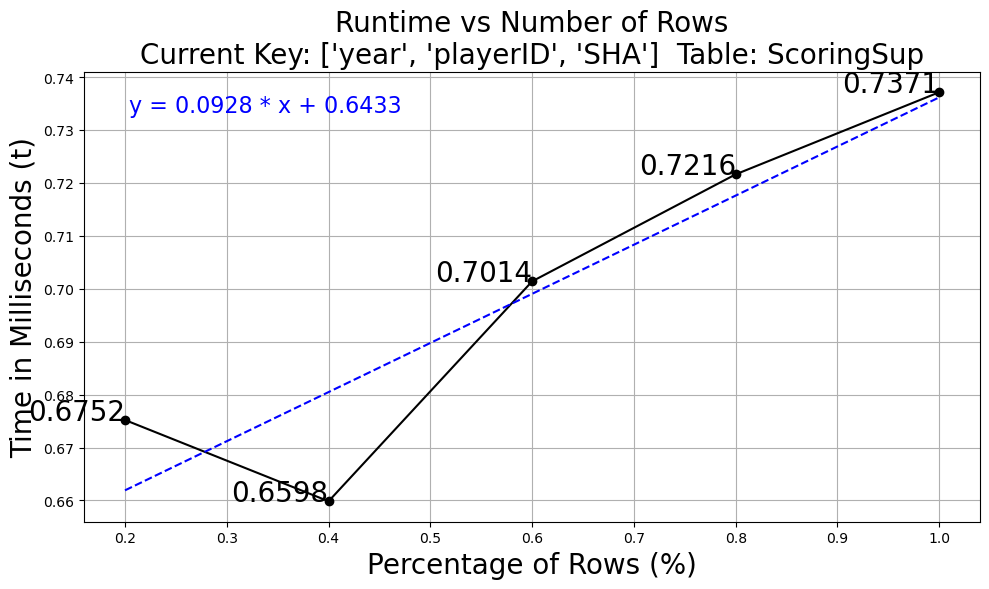

Plot saved successfully as /Users/zihuiyang/Desktop/rowRunTime/ScoringSup.png
Fitting Coefficients: y = 0.0342 * x + 0.6644
R^2: 0.8474


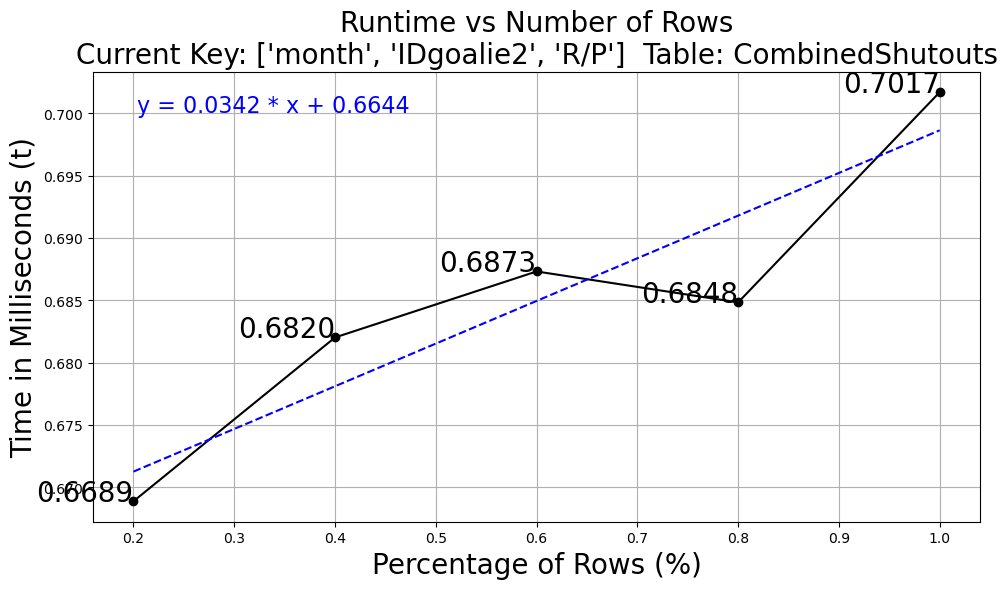

Plot saved successfully as /Users/zihuiyang/Desktop/rowRunTime/CombinedShutouts.png
Fitting Coefficients: y = 0.2479 * x + 0.6905
R^2: 0.9965


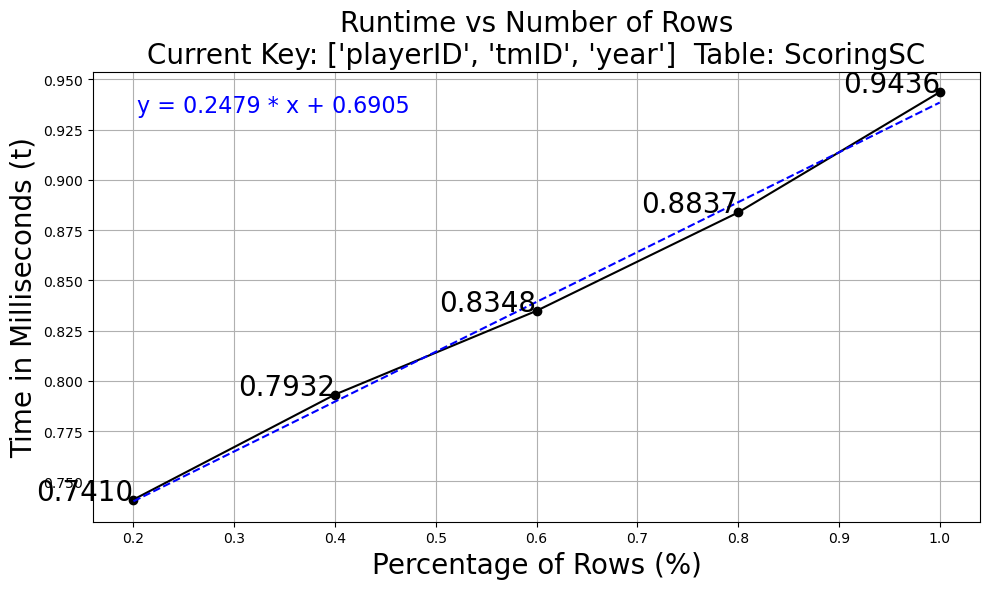

Plot saved successfully as /Users/zihuiyang/Desktop/rowRunTime/ScoringSC.png
Fitting Coefficients: y = 0.0219 * x + 0.6980
R^2: 0.2286


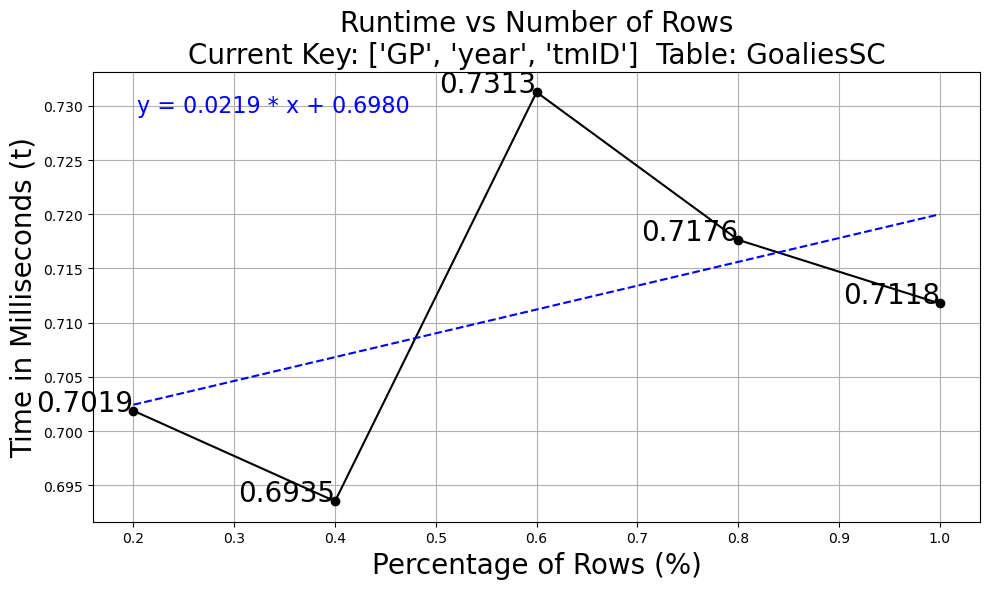

Plot saved successfully as /Users/zihuiyang/Desktop/rowRunTime/GoaliesSC.png
Fitting Coefficients: y = 1.3073 * x + 0.6497
R^2: 0.9645


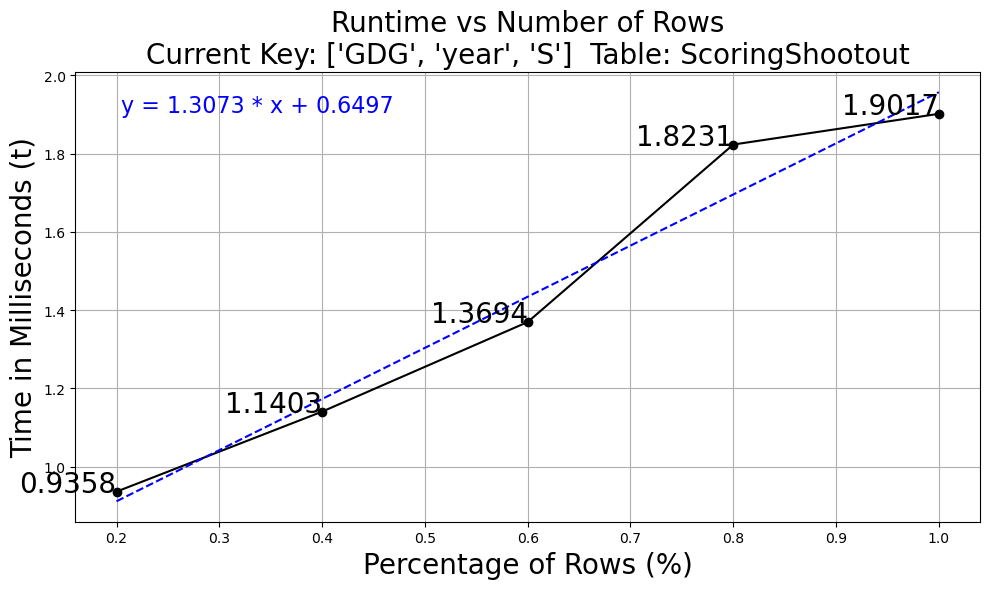

Plot saved successfully as /Users/zihuiyang/Desktop/rowRunTime/ScoringShootout.png
Fitting Coefficients: y = 0.1314 * x + 0.6500
R^2: 0.7309


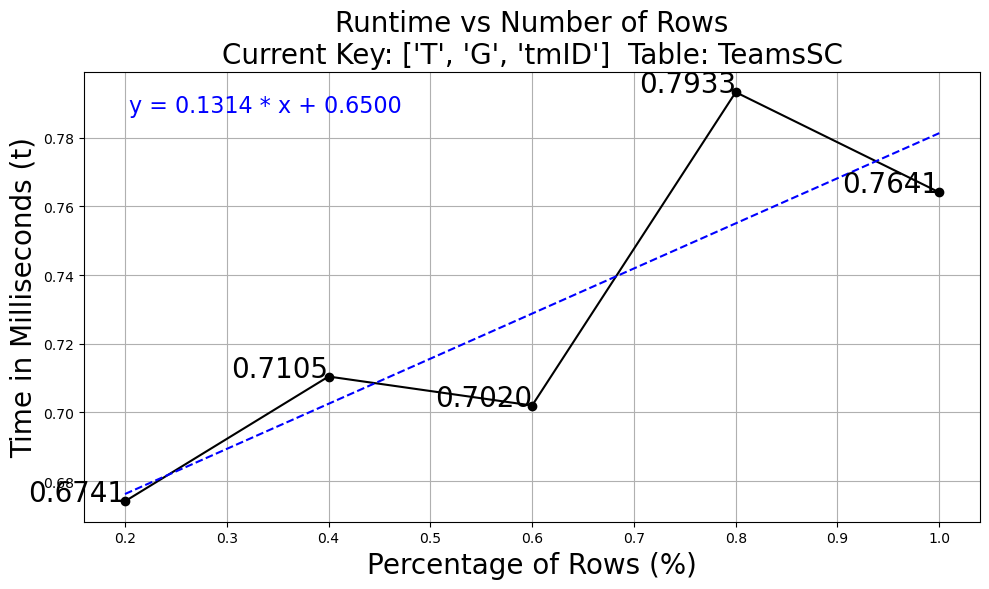

Plot saved successfully as /Users/zihuiyang/Desktop/rowRunTime/TeamsSC.png
total_avg_execution_times_precentage: [{0.2: 1.7063617706298828, 0.4: 2.754831314086914, 0.6: 3.729128837585449, 0.8: 4.461216926574707, 1: 5.1517486572265625}, {0.2: 0.8709907531738281, 0.4: 1.1356353759765625, 0.6: 1.411890983581543, 0.8: 1.7080068588256836, 1: 1.958608627319336}, {0.2: 3.950214385986328, 0.4: 7.107257843017578, 0.6: 10.284256935119629, 0.8: 13.146066665649414, 1: 14.956092834472656}, {0.2: 0.7387161254882812, 0.4: 0.8543491363525391, 0.6: 0.9782552719116211, 0.8: 1.109147071838379, 1: 1.2182235717773438}, {0.2: 0.8294582366943359, 0.4: 0.9774923324584961, 0.6: 1.1332988739013672, 0.8: 1.2601137161254883, 1: 1.3848543167114258}, {0.2: 1.0581016540527344, 0.4: 1.3369083404541016, 0.6: 1.5924453735351562, 0.8: 1.9045114517211914, 1: 2.160024642944336}, {0.2: 10.077214241027832, 0.4: 17.813611030578613, 0.6: 27.617168426513672, 0.8: 37.43939399719238, 1: 43.2652473449707}, {0.2: 0.987505912780761

In [5]:

# total_avg_execution_times = []
# avg_execution_times = main_sql_row('root', 'yzh_20010315', 'hockey', 10, "Master", columns,  [1000, 2000, 3000, 4000, 5000, 6000, 7000])
# total_avg_execution_times.append(avg_execution_times)
# print(total_avg_execution_times)
# [1000, 2000, 3000, 4000, 5000, 6000, 7000]
total_avg_execution_times_precentage = []
total_avg_execution_times=[]
for key, value in random_l1.items():
    avg_execution_times_precentage = main_sql_row_precentage('root', 'yzh_20010315', 'hockey', 10, key, value,  [0.2, 0.4, 0.6, 0.8, 1])
    total_avg_execution_times_precentage.append(avg_execution_times_precentage)
    avg_execution_times = main_sql_row('root', 'yzh_20010315', 'hockey', 10, key, value, [1000, 2000, 3000, 4000, 5000, 6000, 7000])
    total_avg_execution_times.append(avg_execution_times)
print(f"total_avg_execution_times_precentage: {total_avg_execution_times_precentage}")
print(f"total_avg_execution_times: {total_avg_execution_times}")

# Average Running Time

Polynomial Fit (degree=1): y = 3.7318 * x^1 + 0.7571 * x^0
R^2 (degree=1): 0.9954
Polynomial Fit (degree=2): y = -0.7091 * x^2 + 4.5827 * x^1 + 0.5585 * x^0
R^2 (degree=2): 0.9974
Polynomial Fit (degree=3): y = -3.9147 * x^3 + 6.3373 * x^2 + 0.8873 * x^1 + 1.0847 * x^0
R^2 (degree=3): 0.9999
Exponential Fit: y = 1.3775 * e^(1.2049 * x)
R^2 (exponential): 0.9616


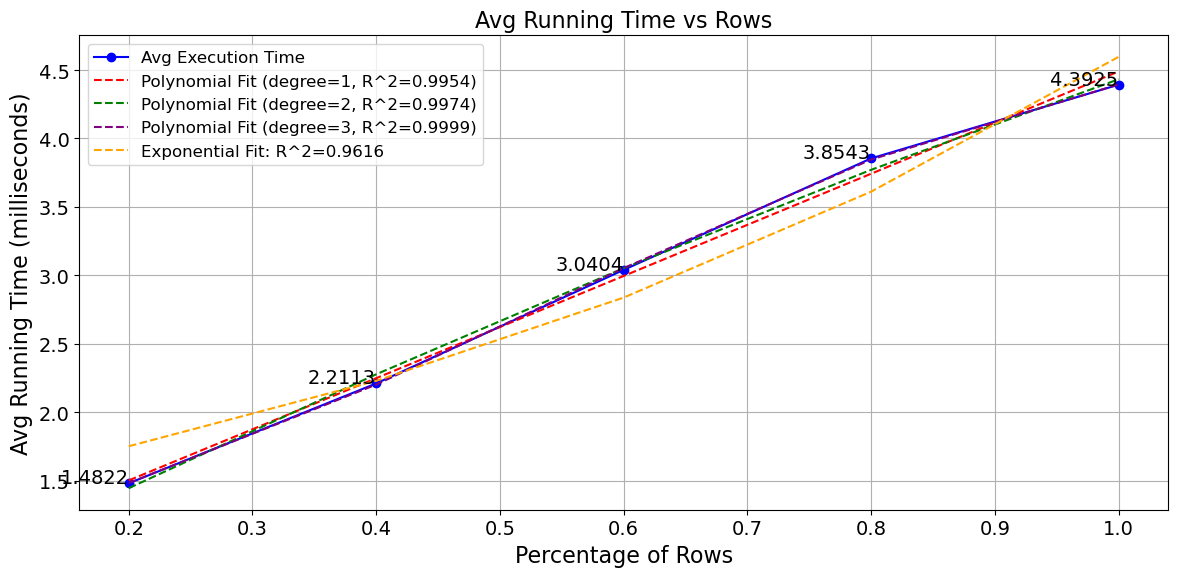

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def fit_curve2(lengths, times, degree=1):
    """Fit a polynomial curve of given degree to the lengths and times."""
    coefficients = np.polyfit(lengths, times, degree)
    polynomial = np.poly1d(coefficients)
    fitted_values = polynomial(lengths)
    SS_res = np.sum((times - fitted_values) ** 2)
    SS_tot = np.sum((times - np.mean(times)) ** 2)
    r_squared = 1 - (SS_res / SS_tot)
    return polynomial, coefficients, r_squared

# Define the exponential function form
def exponential_func(x, a, b):
    return a * np.exp(b * x)

# Data Processing
average_times_precentage = {}
for key in total_avg_execution_times_precentage[0].keys():
    average_times_precentage[key] = sum(d[key] for d in total_avg_execution_times_precentage) / len(total_avg_execution_times_precentage)

keys = np.array(list(average_times_precentage.keys()))
runtime = np.array(list(average_times_precentage.values()))

# Polynomial fitting: degree=1, 2, 3
fit_results = {}
for degree in [1, 2, 3]:
    polynomial, coefficients, r_squared = fit_curve2(keys, runtime, degree=degree)
    fit_results[degree] = {
        'polynomial': polynomial,
        'coefficients': coefficients,
        'r_squared': r_squared
    }

popt, pcov = curve_fit(exponential_func, keys, runtime, p0=(1, 0.1))
a, b = popt
fitted_exponential = exponential_func(keys, a, b)
residuals_exp = runtime - fitted_exponential
SS_res_exp = np.sum(residuals_exp ** 2)
SS_tot_exp = np.sum((runtime - np.mean(runtime)) ** 2)
r_squared_exp = 1 - (SS_res_exp / SS_tot_exp)

# print output
for degree in [1, 2, 3]:
    coefficients = fit_results[degree]['coefficients']
    r_squared = fit_results[degree]['r_squared']
    formula = " + ".join([f"{coefficients[i]:.4f} * x^{len(coefficients) - i - 1}" for i in range(len(coefficients))])
    print(f"Polynomial Fit (degree={degree}): y = {formula}")
    print(f"R^2 (degree={degree}): {r_squared:.4f}")

print(f"Exponential Fit: y = {a:.4f} * e^({b:.4f} * x)")
print(f"R^2 (exponential): {r_squared_exp:.4f}")

plt.rcParams.update({
    'font.size': 14, 
    'axes.titlesize': 16,
    'axes.labelsize': 16,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 12
})


plt.figure(figsize=(12, 6))
plt.plot(keys, runtime, marker='o', linestyle='-', color='b', label='Avg Execution Time')
colors = ['r', 'g', 'purple']
for i, degree in enumerate([1, 2, 3]):
    polynomial = fit_results[degree]['polynomial']
    r_squared = fit_results[degree]['r_squared']
    plt.plot(
        keys,
        polynomial(keys),
        linestyle='--',
        color=colors[i],
        label=f'Polynomial Fit (degree={degree}, R^2={r_squared:.4f})'
    )


plt.plot(keys, fitted_exponential, linestyle='--', color='orange', label=f'Exponential Fit: R^2={r_squared_exp:.4f}')

for i, key in enumerate(keys):
    plt.text(key, runtime[i], f'{runtime[i]:.4f}', fontsize=14, ha='right')

plt.xlabel('Percentage of Rows')
plt.ylabel('Avg Running Time (milliseconds)')
plt.title('Avg Running Time vs Rows')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Polynomial Fit (degree=1): y = 0.0002 * x^1 + 1.1409 * x^0
R^2 (degree=1): 0.9895
Polynomial Fit (degree=2): y = -0.0000 * x^2 + 0.0002 * x^1 + 1.0306 * x^0
R^2 (degree=2): 0.9997
Polynomial Fit (degree=3): y = 0.0000 * x^3 + -0.0000 * x^2 + 0.0003 * x^1 + 1.0016 * x^0
R^2 (degree=3): 0.9999


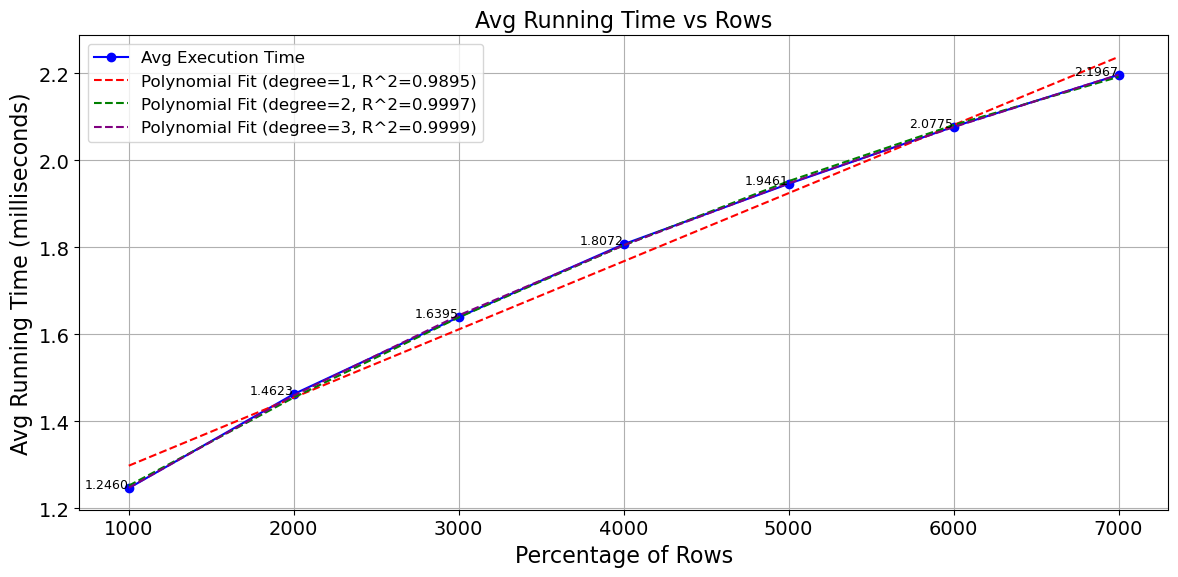

In [7]:
average_times = {}
for key in total_avg_execution_times[0].keys():
    average_times[key] = sum(d[key] for d in total_avg_execution_times) / len(total_avg_execution_times)

keys = np.array(list(average_times.keys()))
runtime = np.array(list(average_times.values()))

fit_results = {}
for degree in [1, 2, 3]:
    polynomial, coefficients, r_squared = fit_curve2(keys, runtime, degree=degree)
    fit_results[degree] = {
        'polynomial': polynomial,
        'coefficients': coefficients,
        'r_squared': r_squared
    }

for degree in [1, 2, 3]:
    coefficients = fit_results[degree]['coefficients']
    r_squared = fit_results[degree]['r_squared']
    formula = " + ".join([f"{coefficients[i]:.4f} * x^{len(coefficients) - i - 1}" for i in range(len(coefficients))])
    print(f"Polynomial Fit (degree={degree}): y = {formula}")
    print(f"R^2 (degree={degree}): {r_squared:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(keys, runtime, marker='o', linestyle='-', color='b', label='Avg Execution Time')

colors = ['r', 'g', 'purple']
for i, degree in enumerate([1, 2, 3]):
    polynomial = fit_results[degree]['polynomial']
    r_squared = fit_results[degree]['r_squared']
    plt.plot(
        keys,
        polynomial(keys),
        linestyle='--',
        color=colors[i],
        label=f'Polynomial Fit (degree={degree}, R^2={r_squared:.4f})'
    )

for i, key in enumerate(keys):
    plt.text(key, runtime[i], f'{runtime[i]:.4f}', fontsize=9, ha='right')

plt.xlabel('Percentage of Rows')
plt.ylabel('Avg Running Time (milliseconds)')
plt.title('Avg Running Time vs Rows')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
